In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np

# ignore all info and warnings but not error messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

Split and scale dataset

In [4]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [5]:
x_train, y_train, x_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


# Q1

For all parts, `train`, `valid`, `test` will be defined as follows:

`train`:
- data that network weights are updated after seeing

`valid`:
- data that network weights are **NOT** updated after seeing

`test`:
- data that network will only see once to evaluate generability(`model.evaluate()`)

As seen below,
```python
y_valid[2] == 2 # integer
```
instead of something like
```python
y_valid == [0 1 0 0 0] # one hot
```
so `sparse_categorical_crossentropy` should be used as opposed to `categorical_crossentropy`

In [6]:
x_valid = x_test
y_valid = y_test
classes = len(df['label'].unique())
y_valid[2]

2

In [7]:
def run_network(
    train,
    valid,
    dropout=.3,
    neurons=16,
    batch_size=1,
    epochs=50,
    callbacks=[],
    summary=False
):
    # clear previous models
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(x_train.shape[1])),
        tf.keras.layers.Dense(neurons, 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(classes, 'softmax')
    ])
    if summary:
        return model.summary()
    
    model.compile(
        tf.optimizers.Adam(),
        metrics='accuracy',
        loss='sparse_categorical_crossentropy'
    )
    return model.fit(
        x=train[0],
        y=train[1],
        verbose=1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        validation_data=valid
    )

Model architecture

In [8]:
history = run_network(
    (x_train, y_train),
    (x_valid, y_valid),
    summary=True
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                928       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 1,098
Trainable params: 1,098
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
history = run_network(
    (x_train, y_train),
    (x_valid, y_valid),
)

Epoch 1/50
700/700 [==============================] - 2s 2ms/step - loss: 2.1724 - accuracy: 0.2214 - val_loss: 1.7421 - val_accuracy: 0.3433
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.7211 - accuracy: 0.3957 - val_loss: 1.5107 - val_accuracy: 0.4667
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.5111 - accuracy: 0.4543 - val_loss: 1.3604 - val_accuracy: 0.5433
Epoch 4/50
700/700 [==============================] - 1s 2ms/step - loss: 1.3730 - accuracy: 0.5157 - val_loss: 1.2752 - val_accuracy: 0.5667
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 1.2583 - accuracy: 0.5343 - val_loss: 1.2186 - val_accuracy: 0.5800
Epoch 6/50
700/700 [==============================] - 1s 2ms/step - loss: 1.2178 - accuracy: 0.5614 - val_loss: 1.1811 - val_accuracy: 0.5833
Epoch 7/50
700/700 [==============================] - 1s 2ms/step - loss: 1.1535 - accuracy: 0.5800 - val_loss: 1.1321 - val_accuracy: 0.5933
Epoch 

In [10]:
import matplotlib.pyplot as plt
def plot_accuracy(history, suptitle_label=''):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=.75 if suptitle_label == '' else .7)

    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    axes[1].plot(history['accuracy'])
    axes[1].plot(history['val_accuracy'])
    axes[1].set_title('Model accuracy')
    axes[1].set(ylabel = 'accuracy', xlabel = 'Epoch')
    axes[1].legend(['Train', 'Valid'], loc='upper left')
    axes[0].plot(history['loss'])
    axes[0].plot(history['val_loss'])
    axes[0].set_title('Model loss')
    axes[0].set(ylabel = 'Loss', xlabel = 'Epoch')
    axes[0].legend(['Train', 'Valid'], loc='upper left')
    
    title = (
        suptitle_label +
        'Min Training loss: {:.{}f}\n'.format(np.min(loss), 3) +
        'Max Training accuracy: {:.{}f}\n'.format(np.max(accuracy), 3) +
        'Min Validation loss: {:.{}f}\n'.format(np.min(val_loss), 3) +
        'Max Validation accuracy: {:.{}f}\n'.format(np.max(val_accuracy), 3)
    )
    f.suptitle(title)

Observations:
- for both loss and accuracy:
    - `valid` diverges from `train` at around epoch 10
- loss diverges a lot more than accuracy

Insights:
- model starts overfitting around epoch 10
    - memorizing `train`
    - learning information (weights updated) that does not generalise to predicting `valid`
- large divergence in loss does not mean large divergence in accuracy
    - not inversely related (although this is intuitive)
    - predictions may become more uncertain
        - probability of predicting `1` when class is indeed `1` decreases but is still the most probable when compared against the other classes, so accuracy may plateau while loss increases

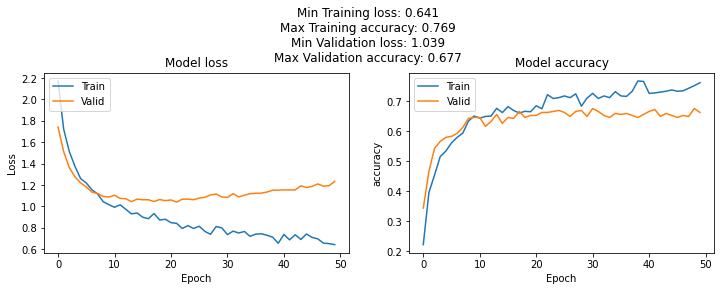

In [11]:
plot_accuracy(history.history)

# Q2

`concatenate` across batch dimension to allow for kfold split

In [12]:
kfold = KFold(n_splits=3, shuffle=True)
x_all = np.concatenate((x_train, x_valid), axis=0)
y_all = np.concatenate((y_train, y_valid), axis=0)

In [13]:
%%time
kfold_history = {}
batch_sizes = [1, 4, 8, 16, 32, 64]

for batch_size in batch_sizes:
    kfold_history[batch_size] = []
    for train, valid in kfold.split(x_all):
        train_x, valid_x = x_all[train], x_all[valid]
        train_y, valid_y = y_all[train], y_all[valid]
        
        history = run_network(
            (train_x, train_y),
            (valid_x, valid_y),
            batch_size=batch_size
        )
        kfold_history[batch_size].append(history)

Epoch 1/50
666/666 [==============================] - 1s 2ms/step - loss: 2.1280 - accuracy: 0.2523 - val_loss: 1.7313 - val_accuracy: 0.3952
Epoch 2/50
666/666 [==============================] - 1s 2ms/step - loss: 1.7072 - accuracy: 0.3814 - val_loss: 1.5003 - val_accuracy: 0.4880
Epoch 3/50
666/666 [==============================] - 1s 2ms/step - loss: 1.5205 - accuracy: 0.4234 - val_loss: 1.3434 - val_accuracy: 0.5629
Epoch 4/50
666/666 [==============================] - 1s 2ms/step - loss: 1.3518 - accuracy: 0.4985 - val_loss: 1.2683 - val_accuracy: 0.5928
Epoch 5/50
666/666 [==============================] - 1s 2ms/step - loss: 1.3010 - accuracy: 0.5225 - val_loss: 1.2055 - val_accuracy: 0.6347
Epoch 6/50
666/666 [==============================] - 1s 2ms/step - loss: 1.2279 - accuracy: 0.5315 - val_loss: 1.1731 - val_accuracy: 0.6228
Epoch 7/50
666/666 [==============================] - 1s 2ms/step - loss: 1.1705 - accuracy: 0.5526 - val_loss: 1.1485 - val_accuracy: 0.6377
Epoch 

667/667 [==============================] - 1s 2ms/step - loss: 0.9225 - accuracy: 0.6582 - val_loss: 0.9559 - val_accuracy: 0.6607
Epoch 16/50
667/667 [==============================] - 1s 2ms/step - loss: 0.9304 - accuracy: 0.6492 - val_loss: 0.9638 - val_accuracy: 0.6697
Epoch 17/50
667/667 [==============================] - 1s 2ms/step - loss: 0.9143 - accuracy: 0.6522 - val_loss: 0.9564 - val_accuracy: 0.6637
Epoch 18/50
667/667 [==============================] - 1s 2ms/step - loss: 0.8467 - accuracy: 0.7136 - val_loss: 0.9271 - val_accuracy: 0.6757
Epoch 19/50
667/667 [==============================] - 1s 2ms/step - loss: 0.9423 - accuracy: 0.6312 - val_loss: 0.9412 - val_accuracy: 0.6637
Epoch 20/50
667/667 [==============================] - 1s 2ms/step - loss: 0.8644 - accuracy: 0.6687 - val_loss: 0.9474 - val_accuracy: 0.6607
Epoch 21/50
667/667 [==============================] - 1s 2ms/step - loss: 0.8268 - accuracy: 0.7046 - val_loss: 0.9424 - val_accuracy: 0.6607
Epoch 22/50

167/167 [==============================] - 0s 3ms/step - loss: 0.9577 - accuracy: 0.6432 - val_loss: 0.9235 - val_accuracy: 0.6877
Epoch 30/50
167/167 [==============================] - 0s 2ms/step - loss: 0.8917 - accuracy: 0.6747 - val_loss: 0.9252 - val_accuracy: 0.6787
Epoch 31/50
167/167 [==============================] - 1s 3ms/step - loss: 0.8901 - accuracy: 0.6777 - val_loss: 0.9194 - val_accuracy: 0.6877
Epoch 32/50
167/167 [==============================] - 0s 2ms/step - loss: 0.9048 - accuracy: 0.6612 - val_loss: 0.9168 - val_accuracy: 0.6877
Epoch 33/50
167/167 [==============================] - 0s 3ms/step - loss: 0.8756 - accuracy: 0.6732 - val_loss: 0.9284 - val_accuracy: 0.6877
Epoch 34/50
167/167 [==============================] - 0s 3ms/step - loss: 0.9024 - accuracy: 0.6702 - val_loss: 0.9094 - val_accuracy: 0.6907
Epoch 35/50
167/167 [==============================] - 0s 3ms/step - loss: 0.8451 - accuracy: 0.6732 - val_loss: 0.9231 - val_accuracy: 0.6847
Epoch 36/50

84/84 [==============================] - 0s 3ms/step - loss: 0.8954 - accuracy: 0.6802 - val_loss: 1.0137 - val_accuracy: 0.6737
Epoch 45/50
84/84 [==============================] - 0s 3ms/step - loss: 0.9018 - accuracy: 0.6607 - val_loss: 1.0207 - val_accuracy: 0.6796
Epoch 46/50
84/84 [==============================] - 0s 3ms/step - loss: 0.9244 - accuracy: 0.6366 - val_loss: 1.0143 - val_accuracy: 0.6766
Epoch 47/50
84/84 [==============================] - 0s 3ms/step - loss: 0.8972 - accuracy: 0.6667 - val_loss: 1.0199 - val_accuracy: 0.6677
Epoch 48/50
84/84 [==============================] - 0s 3ms/step - loss: 0.8666 - accuracy: 0.6847 - val_loss: 1.0072 - val_accuracy: 0.6826
Epoch 49/50
84/84 [==============================] - 0s 2ms/step - loss: 0.8888 - accuracy: 0.6562 - val_loss: 1.0156 - val_accuracy: 0.6677
Epoch 50/50
84/84 [==============================] - 0s 3ms/step - loss: 0.8576 - accuracy: 0.6832 - val_loss: 1.0099 - val_accuracy: 0.6707
Epoch 1/50
84/84 [=======

42/42 [==============================] - 0s 3ms/step - loss: 1.5963 - accuracy: 0.4129 - val_loss: 1.5412 - val_accuracy: 0.4701
Epoch 11/50
42/42 [==============================] - 0s 3ms/step - loss: 1.4955 - accuracy: 0.4760 - val_loss: 1.5032 - val_accuracy: 0.4940
Epoch 12/50
42/42 [==============================] - 0s 3ms/step - loss: 1.5223 - accuracy: 0.4610 - val_loss: 1.4728 - val_accuracy: 0.5120
Epoch 13/50
42/42 [==============================] - 0s 3ms/step - loss: 1.4631 - accuracy: 0.4865 - val_loss: 1.4470 - val_accuracy: 0.5240
Epoch 14/50
42/42 [==============================] - 0s 3ms/step - loss: 1.4775 - accuracy: 0.4745 - val_loss: 1.4221 - val_accuracy: 0.5180
Epoch 15/50
42/42 [==============================] - 0s 3ms/step - loss: 1.4123 - accuracy: 0.5075 - val_loss: 1.3999 - val_accuracy: 0.5329
Epoch 16/50
42/42 [==============================] - 0s 3ms/step - loss: 1.3819 - accuracy: 0.5210 - val_loss: 1.3792 - val_accuracy: 0.5359
Epoch 17/50
42/42 [======

42/42 [==============================] - 0s 3ms/step - loss: 1.1148 - accuracy: 0.6177 - val_loss: 1.1985 - val_accuracy: 0.5796
Epoch 27/50
42/42 [==============================] - 0s 3ms/step - loss: 1.1054 - accuracy: 0.6102 - val_loss: 1.1874 - val_accuracy: 0.5766
Epoch 28/50
42/42 [==============================] - 0s 2ms/step - loss: 1.1514 - accuracy: 0.5967 - val_loss: 1.1800 - val_accuracy: 0.5856
Epoch 29/50
42/42 [==============================] - 0s 3ms/step - loss: 1.0623 - accuracy: 0.6267 - val_loss: 1.1736 - val_accuracy: 0.5976
Epoch 30/50
42/42 [==============================] - 0s 3ms/step - loss: 1.1240 - accuracy: 0.5772 - val_loss: 1.1675 - val_accuracy: 0.5796
Epoch 31/50
42/42 [==============================] - 0s 3ms/step - loss: 1.0663 - accuracy: 0.6177 - val_loss: 1.1626 - val_accuracy: 0.5916
Epoch 32/50
42/42 [==============================] - 0s 3ms/step - loss: 1.1066 - accuracy: 0.5877 - val_loss: 1.1545 - val_accuracy: 0.5886
Epoch 33/50
42/42 [======

21/21 [==============================] - 0s 4ms/step - loss: 1.1514 - accuracy: 0.5802 - val_loss: 1.1205 - val_accuracy: 0.6366
Epoch 43/50
21/21 [==============================] - 0s 4ms/step - loss: 1.1568 - accuracy: 0.5802 - val_loss: 1.1142 - val_accuracy: 0.6336
Epoch 44/50
21/21 [==============================] - 0s 4ms/step - loss: 1.1190 - accuracy: 0.5757 - val_loss: 1.1088 - val_accuracy: 0.6336
Epoch 45/50
21/21 [==============================] - 0s 4ms/step - loss: 1.1030 - accuracy: 0.5877 - val_loss: 1.1041 - val_accuracy: 0.6426
Epoch 46/50
21/21 [==============================] - 0s 4ms/step - loss: 1.0599 - accuracy: 0.6222 - val_loss: 1.0959 - val_accuracy: 0.6366
Epoch 47/50
21/21 [==============================] - 0s 4ms/step - loss: 1.0551 - accuracy: 0.6042 - val_loss: 1.0895 - val_accuracy: 0.6456
Epoch 48/50
21/21 [==============================] - 0s 4ms/step - loss: 1.0697 - accuracy: 0.6192 - val_loss: 1.0863 - val_accuracy: 0.6396
Epoch 49/50
21/21 [======

11/11 [==============================] - 0s 5ms/step - loss: 2.0595 - accuracy: 0.3013 - val_loss: 1.9045 - val_accuracy: 0.3363
Epoch 9/50
11/11 [==============================] - 0s 4ms/step - loss: 1.9495 - accuracy: 0.3328 - val_loss: 1.8563 - val_accuracy: 0.3363
Epoch 10/50
11/11 [==============================] - 0s 5ms/step - loss: 1.9212 - accuracy: 0.3388 - val_loss: 1.8108 - val_accuracy: 0.3544
Epoch 11/50
11/11 [==============================] - 0s 4ms/step - loss: 1.8835 - accuracy: 0.3613 - val_loss: 1.7686 - val_accuracy: 0.3754
Epoch 12/50
11/11 [==============================] - 0s 4ms/step - loss: 1.8417 - accuracy: 0.3583 - val_loss: 1.7289 - val_accuracy: 0.3904
Epoch 13/50
11/11 [==============================] - 0s 5ms/step - loss: 1.7793 - accuracy: 0.3838 - val_loss: 1.6933 - val_accuracy: 0.3934
Epoch 14/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7784 - accuracy: 0.3628 - val_loss: 1.6590 - val_accuracy: 0.4204
Epoch 15/50
11/11 [=======

Observations:
- larger `batch_size` decreases divergence
- `batch_size=32` has smallest divergence and thus is the optimal `batch_size`

Insights:
- useful information is learnt
    - weights updated to improve `train` is generalisable to `valid` as well

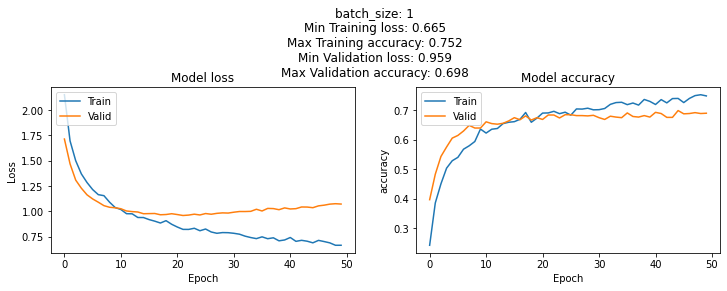

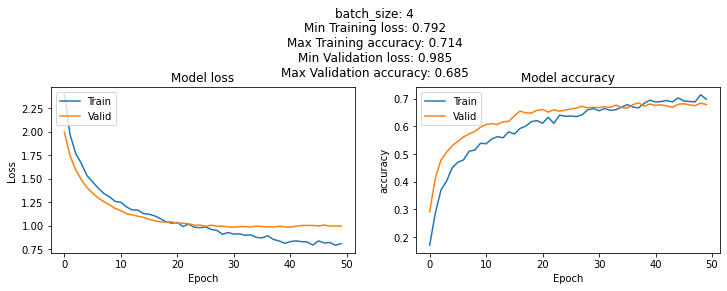

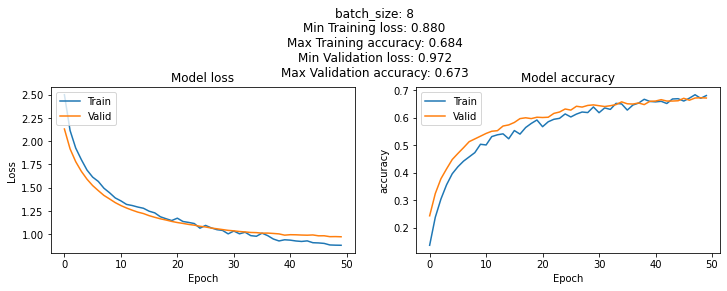

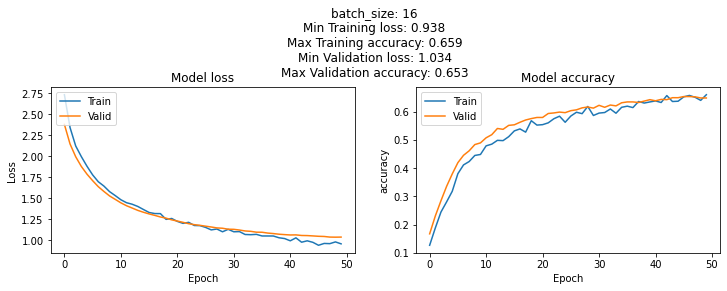

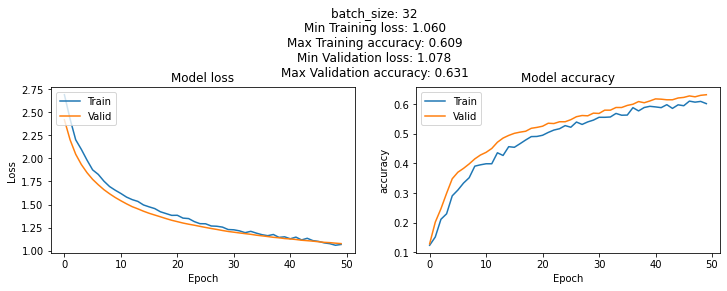

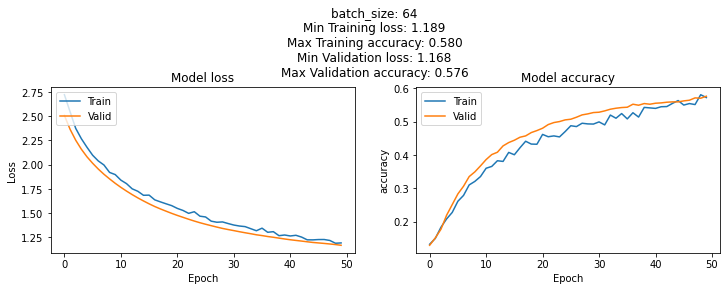

In [14]:
history = {}

for batch_size in batch_sizes:
    for key in kfold_history[1][0].history.keys():
        history[key] = np.mean(
            [h.history[key] for h in kfold_history[batch_size]],
            axis=0
        )
    plot_accuracy(history, suptitle_label=f'batch_size: {batch_size}\n')

In [15]:
import time

class EpochTime(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        global time_taken
        time_taken.append(time.time() - self.start_time)

In [16]:
%%time
time_taken = []

for batch_size in batch_sizes:
    for train, valid in kfold.split(x_all):
        train_x, valid_x = x_all[train], x_all[valid]
        train_y, valid_y = y_all[train], y_all[valid]
        
        history = run_network(
            (train_x, train_y),
            (valid_x, valid_y),
            epochs=1,
            callbacks=[EpochTime()]
        )

667/667 [==============================] - 2s 2ms/step - loss: 2.2044 - accuracy: 0.2534 - val_loss: 1.7871 - val_accuracy: 0.3964
CPU times: user 49.1 s, sys: 3.66 s, total: 52.8 s
Wall time: 33.9 s


In [17]:
table = {k: [] for k in batch_sizes}
for i, t in enumerate(time_taken):
    table[batch_sizes[i // 3]].append(t)
    
table = {k: [round(np.median(table[k]), 2)] for k in table.keys()}
pd.DataFrame.from_dict(table)

,1,4,8,16,32,64
0,1.75,1.84,1.9,1.69,1.78,1.83


- `batch_size=32` is not much slower than the other batches
- `batch_size=32` also results in better generalisation as described before

Thus `batch_size=32` is optimal

In [18]:
%%time
history = run_network(
    (x_train, y_train),
    (x_valid, y_valid),
    batch_size=32
)

Epoch 1/50
22/22 [==============================] - 1s 8ms/step - loss: 2.6233 - accuracy: 0.1386 - val_loss: 2.4619 - val_accuracy: 0.2033
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 2.4027 - accuracy: 0.1886 - val_loss: 2.2936 - val_accuracy: 0.2333
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 2.2297 - accuracy: 0.2371 - val_loss: 2.1733 - val_accuracy: 0.2833
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 2.1575 - accuracy: 0.2757 - val_loss: 2.0719 - val_accuracy: 0.3200
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 2.0070 - accuracy: 0.3300 - val_loss: 1.9938 - val_accuracy: 0.3467
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 1.9704 - accuracy: 0.3257 - val_loss: 1.9360 - val_accuracy: 0.3533
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 1.9194 - accuracy: 0.3243 - val_loss: 1.8801 - val_accuracy: 0.3600
Epoch 8/50
22/22 [==

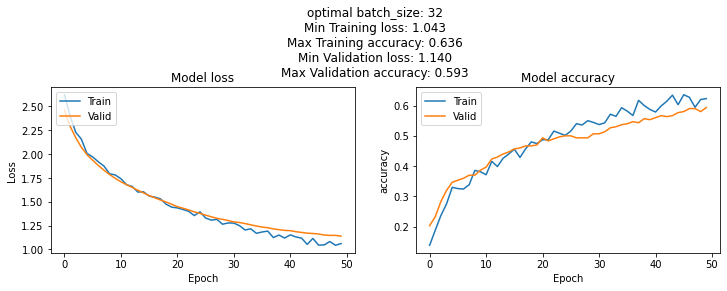

In [19]:
plot_accuracy(history.history, suptitle_label=f'optimal batch_size: 32\n')

minibatch:
- capitalises on vectorisation to train faster (matrix multiplication of `batch_size` number of smaples at one go)

stochastic:
- converges/diverges faster but often at local minima instead of global minima

model training:
- stochastic gradient descent is almost never used

# Q3

In [20]:
%%time
kfold_history = {}
neurons = [8, 16, 32, 64]

for neuron in neurons:
    kfold_history[neuron] = []
    for train, valid in kfold.split(x_all):
        train_x, valid_x = x_all[train], x_all[valid]
        train_y, valid_y = y_all[train], y_all[valid]
        
        history = run_network(
            (train_x, train_y),
            (valid_x, valid_y),
            batch_size=32,
            neurons=neuron
        )
        kfold_history[neuron].append(history)

Epoch 1/50
21/21 [==============================] - 1s 9ms/step - loss: 2.3921 - accuracy: 0.0961 - val_loss: 2.3631 - val_accuracy: 0.0988
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 2.3578 - accuracy: 0.1126 - val_loss: 2.3418 - val_accuracy: 0.0988
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 2.3495 - accuracy: 0.1021 - val_loss: 2.3257 - val_accuracy: 0.0898
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 2.3127 - accuracy: 0.1216 - val_loss: 2.3156 - val_accuracy: 0.0868
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 2.3101 - accuracy: 0.1321 - val_loss: 2.3076 - val_accuracy: 0.0868
Epoch 6/50
21/21 [==============================] - 0s 3ms/step - loss: 2.3025 - accuracy: 0.1216 - val_loss: 2.3028 - val_accuracy: 0.0928
Epoch 7/50
21/21 [==============================] - 0s 3ms/step - loss: 2.2935 - accuracy: 0.1291 - val_loss: 2.2988 - val_accuracy: 0.1228
Epoch 8/50
21/21 [==

21/21 [==============================] - 0s 3ms/step - loss: 2.2076 - accuracy: 0.1589 - val_loss: 2.1768 - val_accuracy: 0.1712
Epoch 18/50
21/21 [==============================] - 0s 3ms/step - loss: 2.1975 - accuracy: 0.1604 - val_loss: 2.1709 - val_accuracy: 0.1712
Epoch 19/50
21/21 [==============================] - 0s 3ms/step - loss: 2.1942 - accuracy: 0.1589 - val_loss: 2.1655 - val_accuracy: 0.1712
Epoch 20/50
21/21 [==============================] - 0s 3ms/step - loss: 2.1856 - accuracy: 0.1619 - val_loss: 2.1585 - val_accuracy: 0.1712
Epoch 21/50
21/21 [==============================] - 0s 3ms/step - loss: 2.1741 - accuracy: 0.1709 - val_loss: 2.1532 - val_accuracy: 0.1802
Epoch 22/50
21/21 [==============================] - 0s 3ms/step - loss: 2.1508 - accuracy: 0.1709 - val_loss: 2.1448 - val_accuracy: 0.1802
Epoch 23/50
21/21 [==============================] - 0s 3ms/step - loss: 2.1679 - accuracy: 0.1679 - val_loss: 2.1403 - val_accuracy: 0.1802
Epoch 24/50
21/21 [======

21/21 [==============================] - 0s 3ms/step - loss: 1.9134 - accuracy: 0.2684 - val_loss: 1.8236 - val_accuracy: 0.3183
Epoch 34/50
21/21 [==============================] - 0s 3ms/step - loss: 1.9342 - accuracy: 0.2519 - val_loss: 1.8080 - val_accuracy: 0.3243
Epoch 35/50
21/21 [==============================] - 0s 3ms/step - loss: 1.8970 - accuracy: 0.2774 - val_loss: 1.7900 - val_accuracy: 0.3333
Epoch 36/50
21/21 [==============================] - 0s 3ms/step - loss: 1.8817 - accuracy: 0.2714 - val_loss: 1.7725 - val_accuracy: 0.3514
Epoch 37/50
21/21 [==============================] - 0s 4ms/step - loss: 1.8814 - accuracy: 0.2699 - val_loss: 1.7533 - val_accuracy: 0.3724
Epoch 38/50
21/21 [==============================] - 0s 3ms/step - loss: 1.8212 - accuracy: 0.2939 - val_loss: 1.7325 - val_accuracy: 0.3814
Epoch 39/50
21/21 [==============================] - 0s 3ms/step - loss: 1.7978 - accuracy: 0.3283 - val_loss: 1.7158 - val_accuracy: 0.3904
Epoch 40/50
21/21 [======

21/21 [==============================] - 0s 3ms/step - loss: 1.4022 - accuracy: 0.4580 - val_loss: 1.4310 - val_accuracy: 0.4970
Epoch 50/50
21/21 [==============================] - 0s 3ms/step - loss: 1.3920 - accuracy: 0.4730 - val_loss: 1.4249 - val_accuracy: 0.5000
Epoch 1/50
21/21 [==============================] - 1s 9ms/step - loss: 2.6289 - accuracy: 0.0810 - val_loss: 2.4319 - val_accuracy: 0.1021
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 2.4130 - accuracy: 0.1319 - val_loss: 2.3128 - val_accuracy: 0.1532
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 2.3290 - accuracy: 0.1739 - val_loss: 2.2220 - val_accuracy: 0.2132
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 2.2442 - accuracy: 0.1979 - val_loss: 2.1465 - val_accuracy: 0.2252
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 2.1631 - accuracy: 0.2264 - val_loss: 2.0759 - val_accuracy: 0.2583
Epoch 6/50
21/21 [============

21/21 [==============================] - 0s 3ms/step - loss: 1.5548 - accuracy: 0.4565 - val_loss: 1.4605 - val_accuracy: 0.4940
Epoch 16/50
21/21 [==============================] - 0s 3ms/step - loss: 1.5413 - accuracy: 0.4550 - val_loss: 1.4371 - val_accuracy: 0.4910
Epoch 17/50
21/21 [==============================] - 0s 3ms/step - loss: 1.5493 - accuracy: 0.4520 - val_loss: 1.4088 - val_accuracy: 0.5150
Epoch 18/50
21/21 [==============================] - 0s 3ms/step - loss: 1.5002 - accuracy: 0.4640 - val_loss: 1.3879 - val_accuracy: 0.5210
Epoch 19/50
21/21 [==============================] - 0s 3ms/step - loss: 1.4937 - accuracy: 0.4700 - val_loss: 1.3650 - val_accuracy: 0.5299
Epoch 20/50
21/21 [==============================] - 0s 4ms/step - loss: 1.4670 - accuracy: 0.4550 - val_loss: 1.3487 - val_accuracy: 0.5359
Epoch 21/50
21/21 [==============================] - 0s 4ms/step - loss: 1.4401 - accuracy: 0.4910 - val_loss: 1.3293 - val_accuracy: 0.5449
Epoch 22/50
21/21 [======

21/21 [==============================] - 0s 3ms/step - loss: 1.2055 - accuracy: 0.5577 - val_loss: 1.2336 - val_accuracy: 0.5976
Epoch 32/50
21/21 [==============================] - 0s 3ms/step - loss: 1.1525 - accuracy: 0.5682 - val_loss: 1.2229 - val_accuracy: 0.5946
Epoch 33/50
21/21 [==============================] - 0s 3ms/step - loss: 1.1491 - accuracy: 0.5847 - val_loss: 1.2125 - val_accuracy: 0.5946
Epoch 34/50
21/21 [==============================] - 0s 4ms/step - loss: 1.1568 - accuracy: 0.5802 - val_loss: 1.2000 - val_accuracy: 0.5946
Epoch 35/50
21/21 [==============================] - 0s 3ms/step - loss: 1.1481 - accuracy: 0.5772 - val_loss: 1.1984 - val_accuracy: 0.6036
Epoch 36/50
21/21 [==============================] - 0s 3ms/step - loss: 1.1160 - accuracy: 0.5922 - val_loss: 1.1879 - val_accuracy: 0.5946
Epoch 37/50
21/21 [==============================] - 0s 3ms/step - loss: 1.0732 - accuracy: 0.6222 - val_loss: 1.1811 - val_accuracy: 0.5976
Epoch 38/50
21/21 [======

21/21 [==============================] - 0s 3ms/step - loss: 0.7884 - accuracy: 0.7286 - val_loss: 0.9549 - val_accuracy: 0.6577
Epoch 48/50
21/21 [==============================] - 0s 3ms/step - loss: 0.7913 - accuracy: 0.7151 - val_loss: 0.9529 - val_accuracy: 0.6667
Epoch 49/50
21/21 [==============================] - 0s 4ms/step - loss: 0.7536 - accuracy: 0.7256 - val_loss: 0.9514 - val_accuracy: 0.6727
Epoch 50/50
21/21 [==============================] - 0s 3ms/step - loss: 0.7509 - accuracy: 0.7316 - val_loss: 0.9456 - val_accuracy: 0.6667
Epoch 1/50
21/21 [==============================] - 1s 9ms/step - loss: 2.7007 - accuracy: 0.1544 - val_loss: 2.3776 - val_accuracy: 0.1381
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 2.2375 - accuracy: 0.2039 - val_loss: 2.0501 - val_accuracy: 0.2312
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 1.9697 - accuracy: 0.2774 - val_loss: 1.8339 - val_accuracy: 0.3303
Epoch 4/50
21/21 [==========

21/21 [==============================] - 0s 3ms/step - loss: 1.0187 - accuracy: 0.6492 - val_loss: 1.0097 - val_accuracy: 0.6637
Epoch 14/50
21/21 [==============================] - 0s 3ms/step - loss: 1.0155 - accuracy: 0.6492 - val_loss: 0.9933 - val_accuracy: 0.6607
Epoch 15/50
21/21 [==============================] - 0s 3ms/step - loss: 0.9642 - accuracy: 0.6792 - val_loss: 0.9692 - val_accuracy: 0.6787
Epoch 16/50
21/21 [==============================] - 0s 3ms/step - loss: 0.9276 - accuracy: 0.6822 - val_loss: 0.9519 - val_accuracy: 0.6727
Epoch 17/50
21/21 [==============================] - 0s 3ms/step - loss: 0.9029 - accuracy: 0.6972 - val_loss: 0.9417 - val_accuracy: 0.6787
Epoch 18/50
21/21 [==============================] - 0s 3ms/step - loss: 0.8956 - accuracy: 0.6957 - val_loss: 0.9214 - val_accuracy: 0.6817
Epoch 19/50
21/21 [==============================] - 0s 3ms/step - loss: 0.8471 - accuracy: 0.6942 - val_loss: 0.9106 - val_accuracy: 0.6967
Epoch 20/50
21/21 [======

Observations:
- `neurons=16`
    - smallest divergence and thus is the optimal `neurons`
    
Insights:
- useful information is learnt
    - weights updated to improve `train` is generalisable to `valid` as well

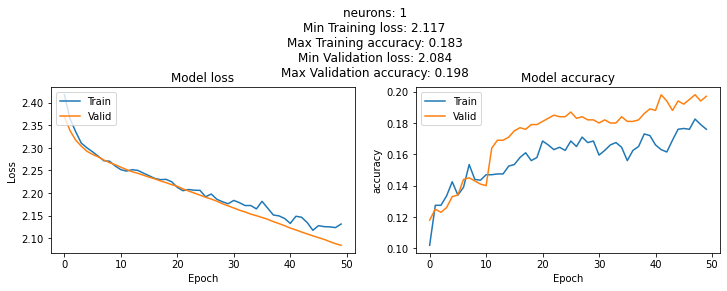

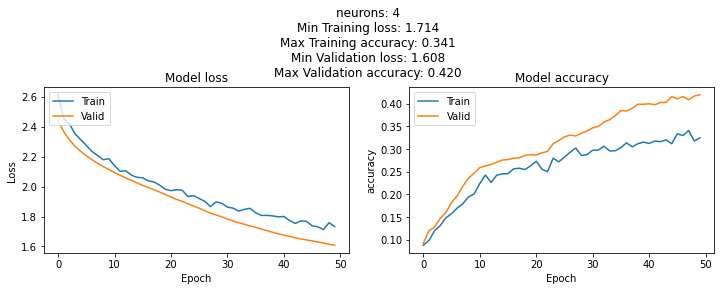

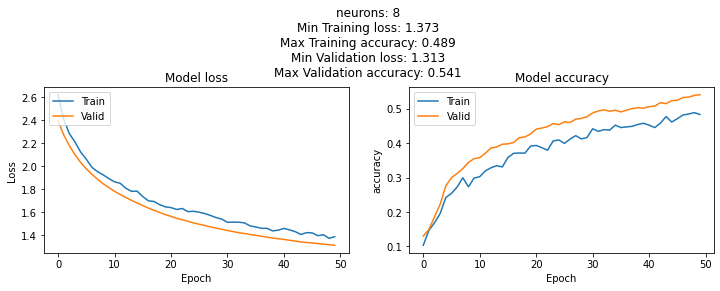

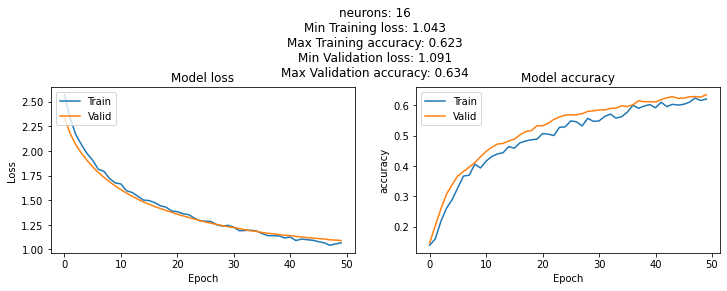

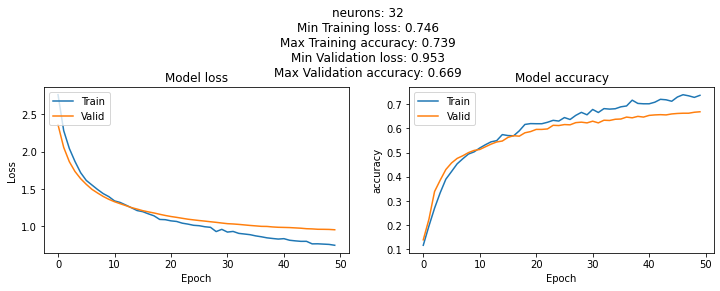

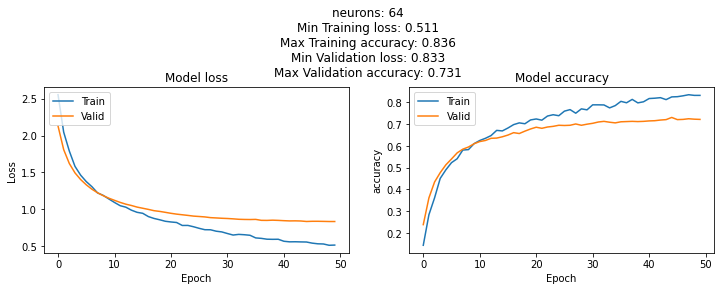

In [21]:
history = {}

for neuron in neurons:
    for key in kfold_history[1][0].history.keys():
        history[key] = np.mean(
            [h.history[key] for h in kfold_history[neuron]],
            axis=0
        )
    plot_accuracy(history, suptitle_label=f'neurons: {neuron}\n')

In [22]:
%%time
history = run_network(
    (x_train, y_train),
    (x_valid, y_valid),
    batch_size=32,
    neurons=16
)

Epoch 1/50
22/22 [==============================] - 0s 9ms/step - loss: 2.7121 - accuracy: 0.0914 - val_loss: 2.3882 - val_accuracy: 0.1167
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 2.3973 - accuracy: 0.1371 - val_loss: 2.1791 - val_accuracy: 0.2067
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 2.1692 - accuracy: 0.2271 - val_loss: 2.0323 - val_accuracy: 0.2900
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 2.0360 - accuracy: 0.2743 - val_loss: 1.9312 - val_accuracy: 0.3267
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 1.9092 - accuracy: 0.3143 - val_loss: 1.8506 - val_accuracy: 0.3433
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 1.8416 - accuracy: 0.3600 - val_loss: 1.7805 - val_accuracy: 0.3667
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 1.7357 - accuracy: 0.3886 - val_loss: 1.7255 - val_accuracy: 0.3900
Epoch 8/50
22/22 [==

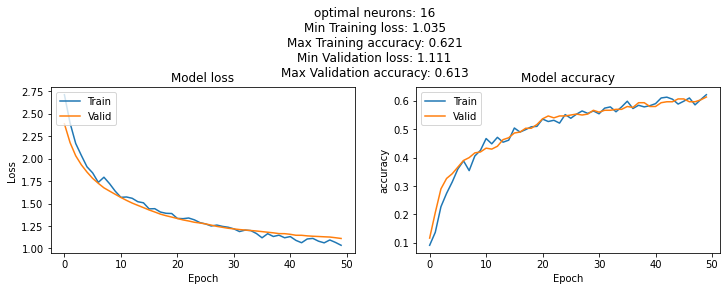

In [23]:
plot_accuracy(history.history, suptitle_label=f'optimal neurons: 16\n')

Other things that can be done:
- hidden layers
    - vary number of hidden layers
    
- learning rate
    - start with `lr>1e-3` which is the default for `Adam`
    - use a learning rate scheduler to decay learning rate as epochs progress
        - big steps towards global minima at early epochs as randomly initialised weights are likely far from good
        - slowly reduce steps as epochs increase as global minima is likely close, want to give chance to find it
        
- optimizer
    - change optimizer
    - tweak optimizer params like `beta_1` for `Adam`
        - usually small improvements and/or not worth the time tweaking
        
- others
    - many other ways that will not be listed here

# Q4

In [24]:
def run_network(
    train,
    valid,
    dropout=.3,
    neurons=16,
    batch_size=1,
    epochs=50,
    callbacks=[],
    summary=False
):
    # clear previous models
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(x_train.shape[1])),
        tf.keras.layers.Dense(neurons, 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(neurons, 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(classes, 'softmax')
    ])
    if summary:
        return model.summary()
    
    model.compile(
        tf.optimizers.Adam(),
        metrics='accuracy',
        loss='sparse_categorical_crossentropy'
    )
    return model.fit(
        x=train[0],
        y=train[1],
        verbose=1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        validation_data=valid
    )

In [25]:
%%time
two_hidden_layer = run_network(
    (x_train, y_train),
    (x_valid, y_valid),
    summary=True
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                928       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,370
Trainable params: 1,370
Non-trainable params: 0
_________________________________________________________________
CPU times: user 45.1 ms, sys: 0 ns, total: 45.1 ms
Wall time: 41.8 ms


In [26]:
%%time
two_hidden_layer = run_network(
    (train_x, train_y),
    (valid_x, valid_y),
)
one_hidden_layer = run_network(
    (train_x, train_y),
    (valid_x, valid_y),
)

Epoch 1/50
667/667 [==============================] - 2s 3ms/step - loss: 2.2965 - accuracy: 0.1574 - val_loss: 2.0960 - val_accuracy: 0.2733
Epoch 2/50
667/667 [==============================] - 2s 3ms/step - loss: 2.0408 - accuracy: 0.2789 - val_loss: 1.8493 - val_accuracy: 0.4174
Epoch 3/50
667/667 [==============================] - 2s 2ms/step - loss: 1.9184 - accuracy: 0.3118 - val_loss: 1.7049 - val_accuracy: 0.4054
Epoch 4/50
667/667 [==============================] - 2s 2ms/step - loss: 1.7748 - accuracy: 0.3433 - val_loss: 1.6122 - val_accuracy: 0.4625
Epoch 5/50
667/667 [==============================] - 2s 2ms/step - loss: 1.6488 - accuracy: 0.3763 - val_loss: 1.5280 - val_accuracy: 0.4865
Epoch 6/50
667/667 [==============================] - 1s 2ms/step - loss: 1.5519 - accuracy: 0.3883 - val_loss: 1.4350 - val_accuracy: 0.5195
Epoch 7/50
667/667 [==============================] - 2s 2ms/step - loss: 1.5122 - accuracy: 0.4393 - val_loss: 1.3677 - val_accuracy: 0.5465
Epoch 

todo

Observations:
- two hidden layer
    - loss diverges at epoch 20
    - loss diverges more
- one hidden layer
    - loss diverges at epoch 30
    - loss diverges less
    
Insights:
- this suggests 2 hidden layers overfits on `train` more as more layers in allows for the model to memorize the `train` data and not generalize to `valid` data

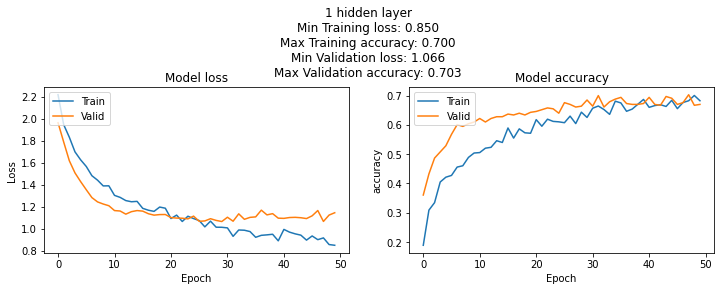

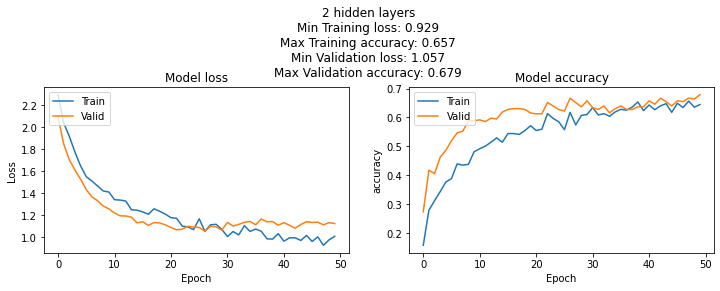

In [27]:
plot_accuracy(one_hidden_layer.history, suptitle_label=f'1 hidden layer\n')
plot_accuracy(two_hidden_layer.history, suptitle_label=f'2 hidden layers\n')

# Q5

In [28]:
def run_network(
    train,
    valid,
    dropout=.3,
    neurons=16,
    batch_size=1,
    epochs=50,
    callbacks=[],
    summary=False
):
    # clear previous models
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(x_train.shape[1])),
        tf.keras.layers.Dense(neurons, 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(classes, 'softmax')
    ])
    if summary:
        return model.summary()
    
    model.compile(
        tf.optimizers.Adam(),
        metrics='accuracy',
        loss='sparse_categorical_crossentropy'
    )
    return model.fit(
        x=train[0],
        y=train[1],
        verbose=1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        validation_data=valid
    )

In [29]:
%%time
no_dropout = run_network(
    (train_x, train_y),
    (valid_x, valid_y),
    dropout=0
)
dropout = run_network(
    (train_x, train_y),
    (valid_x, valid_y),
)

Epoch 1/50
667/667 [==============================] - 2s 2ms/step - loss: 1.9442 - accuracy: 0.3253 - val_loss: 1.5531 - val_accuracy: 0.4535
Epoch 2/50
667/667 [==============================] - 2s 2ms/step - loss: 1.4054 - accuracy: 0.4948 - val_loss: 1.3264 - val_accuracy: 0.5405
Epoch 3/50
667/667 [==============================] - 1s 2ms/step - loss: 1.1748 - accuracy: 0.5787 - val_loss: 1.2296 - val_accuracy: 0.5556
Epoch 4/50
667/667 [==============================] - 1s 2ms/step - loss: 1.0346 - accuracy: 0.6282 - val_loss: 1.1390 - val_accuracy: 0.5916
Epoch 5/50
667/667 [==============================] - 1s 2ms/step - loss: 0.9246 - accuracy: 0.6687 - val_loss: 1.0717 - val_accuracy: 0.6186
Epoch 6/50
667/667 [==============================] - 1s 2ms/step - loss: 0.8397 - accuracy: 0.7121 - val_loss: 1.0131 - val_accuracy: 0.6366
Epoch 7/50
667/667 [==============================] - 1s 2ms/step - loss: 0.7707 - accuracy: 0.7436 - val_loss: 1.0333 - val_accuracy: 0.6637
Epoch 

When dropout is removed, the lack of regularisation causes the model to overfit even more on `train`

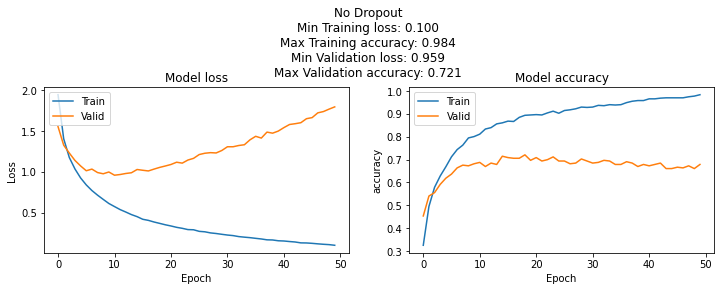

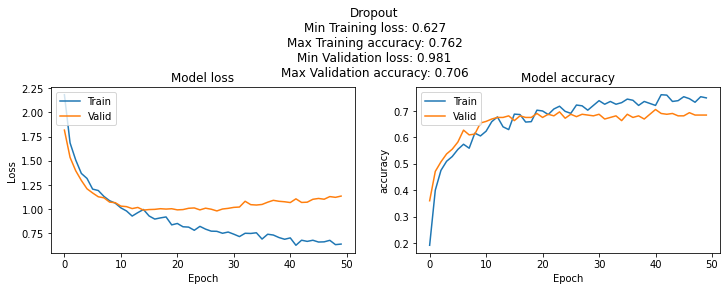

In [30]:
plot_accuracy(no_dropout.history, suptitle_label=f'No Dropout\n')
plot_accuracy(dropout.history, suptitle_label=f'Dropout\n')

Another approach to combat overfitting is `tf.keras.layers.BatchNormalization()`

Normalize output after first hidden layer to have each dimension in a similar scale

# Summary

Instead of using hand crafted features, deep features can be used. For example, audio files can be converted to Mel spectrograms (sample attached below). This can now be approached as a computer vision problem, where (deep) visual features are learnt from the convolutional layers and used for classification instead.

This is much more scalable as deep features are implicitly learnt; in other words, no engineer is needed to think up ways/features to describe each audio file such as harmonics, as these will be implicitly learnt in theory

![mel_sample](mel_spectrogram.png)

In [15]:
kfold_history

{1: [<keras.callbacks.History at 0x7f68a8475990>,
 4: [<keras.callbacks.History at 0x7f696805c590>,
 8: [<keras.callbacks.History at 0x7f68987c5410>,
 16: [<keras.callbacks.History at 0x7f689a6e2750>,
 32: [<keras.callbacks.History at 0x7f689a2a08d0>,
 64: [<keras.callbacks.History at 0x7f689a76a850>,
  <keras.callbacks.History at 0x7f6899de9990>]}